# Anomaly Detection in Time Series (AC209a Final Project)
*Stephen Robbins and Ryan Lapcevic*

* [Overview](https://snibborevets.github.io/bad_wiki_edits/overview)
* [Key Concepts](https://snibborevets.github.io/bad_wiki_edits/overview)
* [Simple Anomaly Detection](https://snibborevets.github.io/bad_wiki_edits/data)
* [Deterministic Power Martingales](http://www.ffwizard.com/)
* [Randomized Power Martingales](http://www.ffwizard.com/)
* [Adiabatic Iterative Support Vector Machines](http://www.ffwizard.com/)
* [Conclusion](http://www.ffwizard.com/)
* [Works Cited](http://www.ffwizard.com/)

---

## Deterministic Power Martingales

- [Vovk Implementation](#Vovk-Implementation)
- [Load and Clean USPS Data](#Load-and-Clean-USPS-Data)
- [Run Martingale Functions on USPS Data](#Run-Martingale-Functions-on-USPS-Data)
- [Comparison to Vovk Paper](#Comparison-to-Vovk-Paper)
- [Run Martingale Functions on S&P 500 Data](#Run-Martingale-Functions-on-S&P-500-Data)
- [Discussion](#Discussion)

---

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true;
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
}
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

---

***Import Libraries***

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn as sk
import datetime
%matplotlib inline

from scipy.spatial.distance import euclidean
from sklearn.svm import OneClassSVM
from sklearn.cluster import MiniBatchKMeans
from luminol import *
from luminol.modules.time_series import TimeSeries
from luminol.anomaly_detector import AnomalyDetector

---

### Vovk Implementation


***Nearest-Neighbors Martingales Functions from "Testing Exchangeability On-Line"***

Our goal here was to re-create the analysis done in Vovk's "Testing Exchangeability On-Line". We used the same dataset from their paper. The data set contains image data of distinct handwritten digits and was generated from mail data provided by the United States Postal Service. As part of a study in the 1990s, the USPS and researchers hired contractors to categorize 9,282 separate digits, 0 to 9, written on mail. The image of each digit was stored in the form of 256 pixels (16x16). 

We were able to find the data here: http://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/multiclass.html#usps. The data is separated into training and testing sets, but we combined them into one data set similar to Vovk. Our "x" data contains the image data of the 256 pixels. Our "y" data contains the categorized digit (0-9).

Our anomaly functions below receive data in time-series fashion --- one sample at a time. Since our data set is known to be heterogeneous, it's useful for detecting anomalies as we would not expect our data to be exchageable. 

Given the size of the data set, we were only able to run our martingale function on a subset of the data: the first 500 points. As shown below, however, we were able to repoduce the results in Vovk.

***FUNCTION: Strangeness - Nearest-Neighbor Method***

The "strangeness function" is used to determine how different a given sample is from other samples with the same label. As we receive data one-sample at a time, we compare a given sample to the *previous samples only*. 

The method we use below mimics that of Vovk: the Nearest Neighbor method. For each sample in sequence, we calculate the ratio between the:
- Minimum euclidian distance between the sample and all previous samples with the *same label*; and the
- Minimum euclidian distance between the sample and all previous samples with a *different label*.

In other words, we're determining strangeness by seeing (1) how different our sample is from samples with the same label and (2) how similar our sample is to points with a different label.

In [3]:
# FXN:  inputs: x and y datasets, starting point in dataset to begin analysis, and the ending point where we stop our analysis
#       output: array of strangeness values for each sample

def strangeness_nn(x, y, start_point, end_point):

    n = len(x)
    num_array = []    # make blank arrays for storing distance values below 
    denom_array = []
    
    if start_point == 0:   # can not determine eucl. distance with only one point.
        start_point = 1
    
    # iterate through each sample in sequence, our "target" sample
    for i in range(start_point, end_point):

        min_dist_num = 100000      # set high starting minimum distance values 
        min_dist_denom = 100000


        # iterate through every sample in sequence receive prior to the "target" sample
        for j in range(0, i):

            # if "target" sample has the same label...
            if y.iloc[i] == y.iloc[j]:

                # ...calculate the euclidian distance...
                dist_num = euclidean(x.iloc[i, :], x.iloc[j, :])

                #...and store value if it's the smallest distance calculated so far. 
                if dist_num < min_dist_num:
                    min_dist_num = dist_num
                    
            # if "target" sample has different label...
            elif y.iloc[i] <> y.iloc[j]:

                # ...calculate the euclidian distance...
                dist_denom = euclidean(x.iloc[i, :], x.iloc[j, :])

                #...and store value if it's the smallest distance calculated so far.
                if dist_denom < min_dist_denom:
                    min_dist_denom = dist_denom

        # store same-label minimum distances and different-label minimum distances into arrays  
        num_array.append(min_dist_num)
        denom_array.append(min_dist_denom)

    # compute our strangeness array with stored values
    strangeness_array = np.divide(num_array, denom_array)
    
    # return strangeness array
    return strangeness_array

***FUNCTION: Calculate p-values of Strangeness Array*** 

Next, we calculate our "p-values" per the Vovk paper. The p-value determines relative strangeness: the strangeness a given sample compared to the strangeness of previous samples. Given a sample, we count the number of times this sample has a lower strangeness value than previous samples' strangeness values. Then, we divide this by the number of samples we've received. 

Vovk describes these p-values as "confidence tranducers" --- put simply, the p-values indicate how confident we are that a given point should be considered anomaly or not.

It is also worth pointing out that the function below corresponds to what Vovk refers to as a "deterministic confidence transducer." This is in contrast to a "randomised confidence transducer," which adds a random variable between 0 and 1 to the numerator. This simple addition to the numerator simply ensures that no two p-values are the same.

In [4]:
# FXN:  input: array of strangeness values for each sample
#       output: array of p-values for each sample

def p_values(strangeness_array):

    p_val_array = [1]  # set initial p-value to 1
    
    
    # iterate through each "target" sample in strangeness array
    for i in range(1, len(strangeness_array)):

        count = 0.0    #set initial count to zero

        # for each "target" sample, iterate through all previous strangeness points...
        for j in range(0, i):

            # each time the "target" sample's strangeness is less than a previous sample's strangeness...
            if strangeness_array[i] < strangeness_array[j]:
                
                # increase count by 1
                count = count + 1.

        # per paper, p-val is #{i: αi ≥ αn} / n  --- strangeness at n is less than or equal to prev samples INCLUDING at n.
        p_val = (count + 1) / (i + 1)  

        # add p-value to our array
        p_val_array.append(p_val)
        
    # return the array of p-values
    return p_val_array

***FUNCTION: Calculate Martingale Values***

Finally, we calculate our martingale values. The martingale function is cumulative in nature, as each martingale value is calculated by multiplying a sample's relative strangeness (p-value) every previous samples' p-values. A tuning paramter, epsilon, is incorporated into this function to both yield better results and normalize our data.

It's worth noting that because of the manner in which epsilon "tunes" our values below (p-values to the *power* of 1 minus epsilon), Vovk describes these martingales as "Power Martingales."

In [5]:
# FXN:  input: p-values of samples and tuning parameter, epsilon
#       output: array of martingale values

def martingale_values(p_val_array, epsilon):

    martingale_array = [1]    # set initial value to 1

    # iterate through each p-value
    for i in range(1, len(p_val_array)):

        # calculate the "target" sample's individual martigale value based on it's p-value and our tuning parameter
        martingale_at_i = epsilon * (p_val_array[i] ** (epsilon - 1))

        # multiply the "target" sample's value by the previous value in the martingale array
        martingale_val = martingale_at_i * martingale_array[i - 1]

        # store this value in the martingale array
        martingale_array.append(martingale_val)
    
    #return array of martingale values
    return martingale_array

---

### Load and Clean USPS Data

NOTE: Data sets downloaded from link above were very clean. Very minor formatting was needed before loading data, which we completed in Excel.

In [6]:
# load training and testing sets
train = pd.read_csv('usps_train.csv')
test = pd.read_csv('usps_test.csv')

# per Vovk, combined training and testing data sets
data = pd.concat((train, test), axis=0)

# make x- and y- arrays
y = data.iloc[:, -1]
x = data.iloc[:, :-1]

---

### Run Martingale Functions on USPS Data

In order to replicate Vovk's output in figure 1, we need to:
1. Run our data through the strangeness and p-value functions above;
2. Create range of epsilon values between 0 and 1 (for x-axis)
3. Run our martingale function for each epsilon value
4. For each epsilon value, calculate the log (base 10) of the *final* martingale value (for y-axis)

As the martingale output is cumulative, we are concerned with the *final* value of each martingale for a given epsilon. 

In [7]:
# establish starting and ending points on data sets for analysis
start_point = 100
end_point = 500

# run USPS dataset through functions above
strangeness_array_nn = strangeness_nn(x, y, start_point, end_point)
p_val_array_nn = p_values(strangeness_array_nn)

In [8]:
# create array of epsilon values between 0 and 1
epsilon_range = np.arange(0, 1.01, 0.1)

# set first value to 0.01 (can't be zero because we're taking the log later...)
epsilon_range[0] = 0.01

# create array to store values for y-axis
log_final_mart_array = []

# iterate through each epsilon value
for i in range(0, len(epsilon_range)):

    # run the martingale function for each epsilon
    martingale_array_nn = martingale_values(p_val_array_nn, epsilon_range[i])
    
    # compute the log (base 10) of the final value in the martingale array
    log_final_mart_val = np.log10(martingale_array_nn[-1])

    # store this value into an array (for our y-axis below)
    log_final_mart_array.append(log_final_mart_val)

---

### Comparison to Vovk Paper

To compare our methods, we graph our results just as in Figure 1 of the Vovk paper: x = epsilon value range; y = log of final martingale value.

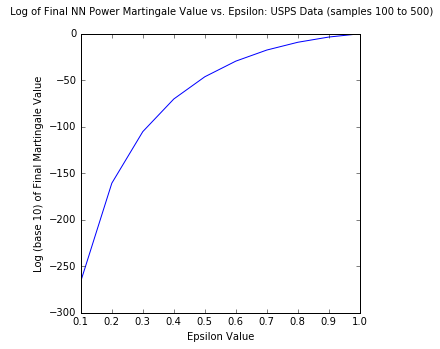

In [9]:
# create plot
fig, ax = plt.subplots(figsize=(5,5))

# plot our epsilon range versus the log of our final martingale values
ax.plot(epsilon_range, log_final_mart_array)

# set chart attributes
ax.set_title(' Log of Final NN Power Martingale Value vs. Epsilon: USPS Data (samples ' + str(start_point) + ' to ' + str(end_point) + ')', fontsize=10)
ax.set_xlabel('Epsilon Value')
ax.set_ylabel('Log (base 10) of Final Martingale Value')
ax.title.set_position([.5, 1.05])

# show plot
plt.show()

**VOVK FIGURE 1 - NN Power Martingales as Function of Epsilon: Full USPS Dataset**

<img style="float: left;" src="vovk_fig1.jpg">

---

### Run Martingale Functions on S&P 500 Data

---

### Discussion

We were able to successfully implement the Nearest-Neighbor Power Martingale as outlined in the Vovk paper. Although we were only able to use a subset of the data, directionally our results are identical. As we increase our subset range, our initial martingale values start from a lower value and asymptomatically approach zero.

---